# Step 1 (NOTES):
# NE204 Lab 1: Pulse Processing 
__Dates: 08/2022 to 10/2022.__

__Group: Megan Schiferl, Chris Lamb, Curtis Berger, Jisu Park__


__Contents:__
This notebook contains notes on a lot of the functions that were tried as well as more visuals for each step of the process from raw pulses to finding the trapezoid height. All methods are explored, only some are used going forward.

1. Imports & Directory
2. DAC Echo Correction
3. Saving Raw Data to Array
4. Removing Saturation
5. Background Subtraction
6. Applying a Savinsky-Golay Filter
7. Noise Height Investigation
8. Finding Start of Rise (i) and Rise Time (k)
    Versions 1 - 3
9. Finding Tau
10. Defining the Trapezoidal Filter
11. Apply Trapezoidal Filter
12. Fit Trapezoids
13. Finding the Trapezoid Height
      Max Value, Trapezoid Fit, and Gradient Methods
 
__Notes on Running__
 - You'll need to change the directory and file name, but otherwise, run all should do the trick.

# Section 1: Imports & Directory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import pandas as pd
from scipy import signal
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import os
from tqdm import notebook
import matplotlib.style as mplstyle

In [2]:
# change directory
os.chdir(r'C:/Users/megas/Documents/Cal/NEFall2022/Detectors204/lab1/')

#check current working directory
retval = os.getcwd()
print ("Current working directory %s" %retval)

Current working directory C:\Users\megas\Documents\Cal\NEFall2022\Detectors204\lab1


In [3]:
#Input the data file and find the keys
#Note: Stick to files with < 5000 pulses in this notebook. it's not set up to handle more than that
f = h5py.File(r"C:\Users\megas\Documents\Cal\NEFall2022\Detectors204\lab1\923Data\Cs137-1min.h5", 'r')

length = input("What is the length (in time) of this file?")
isotope = input("What isotope did you measure?")

#print the keys for the file path
print(f.keys())
print(f['raw_data'])

What is the length (in time) of this file?1min
What isotope did you measure?Cs137
<KeysViewHDF5 ['event_data', 'raw_data']>
<HDF5 dataset "raw_data": shape (3162, 62500), type "<u2">


# Section 2: DAC Echo Correction
 - Upon checking the timestamp information in event data, it is clear that the last second of data is repeated.

3115


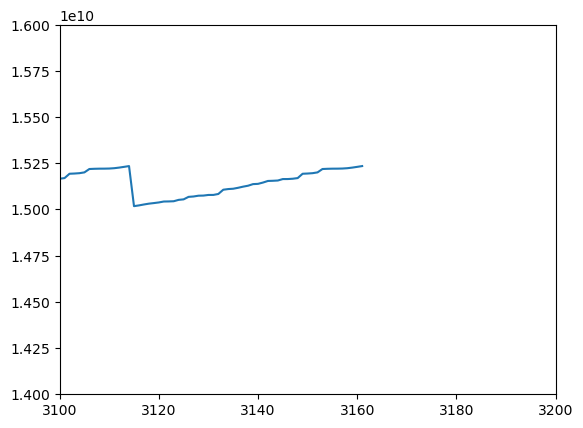

In [4]:
#The second of data is repeated - remove from consideration
plt.xlim(3100,3200)
plt.ylim(1.4e10,1.6e10)
plt.plot(f['event_data']['timestamp'])

repeat = np.argmin(f['event_data']['timestamp'][3100:3200])
print(repeat+3100)

# Section 3: Saving the useful raw data to an array 
 - Saved raw data to an array for easy access
 - Removed the DAC Echo
 - Plotted the raw pulses to check pulse shape: expected to find ~1000 pre-trigger delay time, then a sharp rise, and a long exponential decay


In [5]:
pulses = np.array(f['raw_data'])
pulses = pulses[0:3115]

print("The number of pulses after DAC correction is:", len(pulses))
print("The length of each pulse is:", len(pulses[0]))
print("The number of pulsesX arrays you need is:", int(len(pulses)/5000)+1)

The number of pulses after DAC correction is: 3115
The length of each pulse is: 62500
The number of pulsesX arrays you need is: 1


  0%|          | 0/100 [00:00<?, ?it/s]

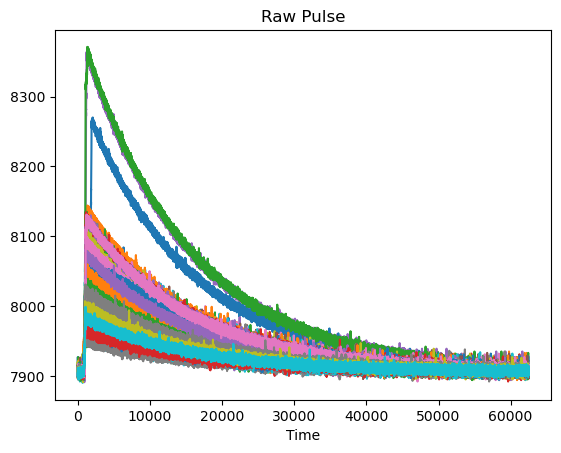

In [6]:
#Plot the raw data
plt.figure()

for i in notebook.tqdm(range(0, 100)):
    plt.plot(np.arange(pulses[i].size), pulses[i])
    plt.xlabel('Time')
    plt.title('Raw Pulse')

# Section 4: Removing Saturated Signals
 - Identified the value of saturation
 - Created a new array which holds only the non-saturated pulses

In [7]:
#remove saturated signals
sat = np.amax(np.amax(pulses))
print("The saturation value is", sat)

nonsat_pulses = []
for i in range(len(pulses)):
    max_y = np.amax(pulses[i])
    if (max_y != sat):
        nonsat_pulses.append(pulses[i])

nonsat_pulses = np.array(nonsat_pulses)
print("There are", len(pulses), "total pulses.")
print("There are", len(nonsat_pulses), "non-saturated pulses.") 

The saturation value is 16383
There are 3115 total pulses.
There are 3089 non-saturated pulses.


# Section 5: Background Subtract
 - First looking at the noise and finding some noise heights above the mean
 - Find the mean of the noise floor
 - Subtract the noise floor from the non-saturated pulses

<class 'numpy.ndarray'>


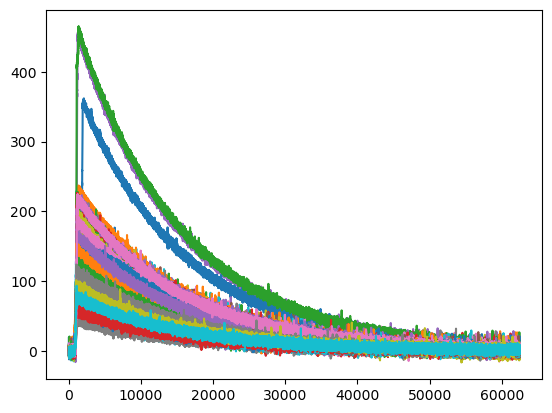

In [8]:
#Background subtraction for the raw data
n = len(nonsat_pulses)
print(type(nonsat_pulses))
pulses_sub = []
for i in range(n):
    bkg = np.mean(nonsat_pulses[i][0:500])
    pulses_sub.append(nonsat_pulses[i] - bkg)
    
pulses_sub = np.array(pulses_sub)
for i in range(100):
    plt.plot(pulses_sub[i])

# Section 6: Applying a Savinsky-Golay Filter
 - Our trapezoidal filters don't work well without noise filtering, so savgov it is

(3089, 62500)


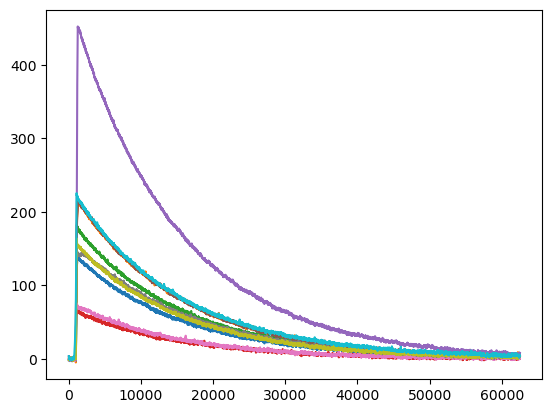

In [9]:
#filtering the signals
fs = savgol_filter(pulses_sub, 51, 2)
print(fs.shape)
for i in range(10):
    plt.plot(fs[i])

# Section 7: Noise Height
 - Looking at the filtered noise height 

The average noise height is: 2.2240526580092794
The minimum noise height is: 1.3414346870822242 The maximum noise height is: 5.614360112695165


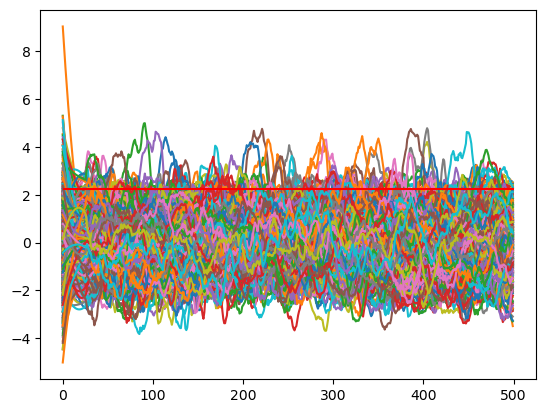

In [10]:
#Plotting the pre-trigger area for a look at the background
#getting the average noise height
noiseh = []
noisemin_ar = []
noisemax_ar = []
plt.figure()
for i in range(1000):
    plt.plot(fs[i][0:500])
    noisemin = np.amin(fs[i][0:500])
    noisemin_ar.append(noisemin)
    noisemax = np.amax(fs[i][0:500])
    noisemax_ar.append(noisemax)
    half = (noisemax-noisemin)/2
    noiseh.append(half)
avg_noiseh = np.mean(noiseh)
plt.hlines(np.amin(avg_noiseh), 0, 500, colors="r", label = 'Average Noise Height: {}'.format(np.amin(avg_noiseh)))

print("The average noise height is:", avg_noiseh)
print("The minimum noise height is:", np.amin(noiseh), "The maximum noise height is:", np.amax(noiseh))

# Section 9: Finding Start of Rise (i) and Rise Time (k)
   > Version 1: Trying to find the upper and lower bounds of the rise time using the max value of the signal and the median of a difference array, respectively. This version does an okay job at all of these things. A histogram is shown for the given maximum peak value (via np.argmax) and it's clear that depending on the signal, this does a good, decent, and horrible job of finding the actual end of the rise. 
   
   > Version 2: Finds the cumulative standard deviation of the pulse, calculates the gradient of the cumulative standard deviations, and determines the start and end of the rise via the max and min of the gradient of the cumulative standard deviations, respectively. As seen in the graph that shows the pulse vs the gradient of the std deviations, this method chooses an i that is slightly too high. 
   
   > Version 3: This one seems to be a winner - go Chris! Here we take the gradient of the pulse anywhere that the signal is 8 * sigma greater than the mean of the noise floor, and everywhere else, we set to zero. If there are any noise bumps before the actual signal rise, the gradient will become negative within some window of time. So we check for that occurance, and if it doesn't happen, we have identified the rise. Since we have identified the index at 8 sigma above the mean, we need to shift back to the left a few channels, and we're there!
   
__Moving On: using version 3 as the i value, and k will be set approximately at 350 for all signals. This is optimized in the next notebook.__

<class 'numpy.ndarray'> (3089, 62500)


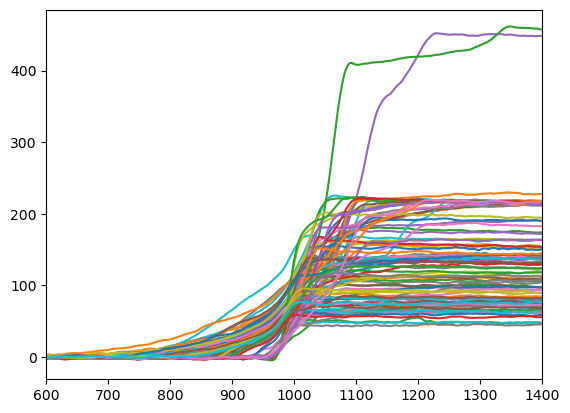

In [11]:
#Plotting the rise of a bunch of data to see possible pileup
for i in range (100):
    plt.plot(fs[i]) 
    plt.xlim(600,1400) #we expect the rise to be around the pre-trigger value 1000t
    
print(type(fs), fs.shape)

In [12]:
#Version 1 of rise time determination
def get_k_v1(signal):
    end_index = np.argmax(signal)
    diff_list = []
    N = 0
    diff_array = np.array([signal[end_index] - signal[end_index - n] for n in range(end_index)])
    med = np.median(diff_array)
    for n in range(len(diff_array)):
        if diff_array[n]>0.998*med:
            N = n
            break
    return N

k_array = []
for i in range(len(fs)):
    k_array.append(get_k_v1(fs[i]))

kavg = np.mean(k_array)
k = round(kavg, 0)
print("The average rise time (based on version 1) is:", k)

The average rise time (based on version 1) is: 350.0


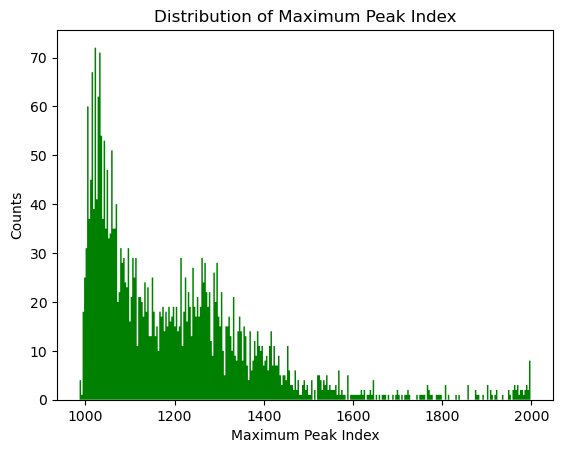

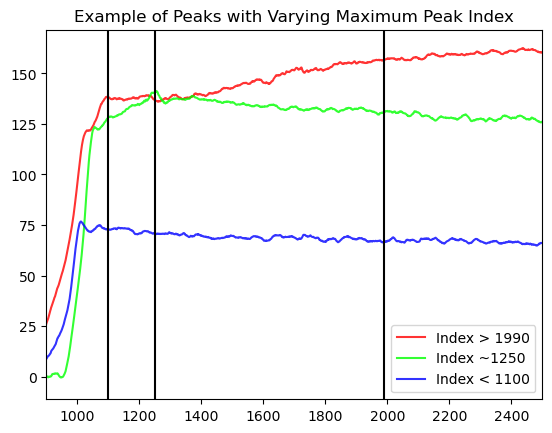

In [13]:
#find the index of the max value for each fitted signal
imax = []
for i in range(len(fs)):
    if np.argmax(fs[i][0:2000]) != 1999:
        imax.append(np.argmax(fs[i][0:2000])) # only looking at the first 2000 to avoid late pileup signals

#Plot this out as a histogram to see what the results look like
#This gets a little bit into what we are doing in lab 2 so I won't do much more here.
imax_hist, imax_bins = np.histogram(imax, bins = 300)
plt.figure()
plt.title("Distribution of Maximum Peak Index")
plt.xlabel("Maximum Peak Index")
plt.ylabel("Counts")
plt.hist(imax_bins[:-1], imax_bins, weights = imax_hist, histtype='stepfilled', color = 'g')

#Multiple unexpected values, both high, and around 1250, so let's plot the signals to see what's going on
high_imax = []
plt.figure()
plt.title("Example of Peaks with Varying Maximum Peak Index")
plt.xlim(900, 2500)
for i in range(len(imax)):
    if imax[i] > 1990:
        high_imax.append(fs[i])        
high_imax = np.array(high_imax)
for i in range(1):
    plt.plot(high_imax[i], label = "Index > 1990", c = (1,0,0,0.2*(5-(i+1))))
    
mid_imax = []
for i in range(len(imax)):
    if 1200 <= imax[i] <= 1300:
        mid_imax.append(fs[i])
mid_imax = np.array(mid_imax)
for i in range(1):
    plt.plot(mid_imax[i], label = "Index ~1250", c = (0,1,0,0.2*(5-(i+1))))
    
low_imax = []
for i in range(len(imax)):
    if imax[i] < 1100:
        low_imax.append(fs[i])
low_imax = np.array(low_imax)
for i in range(1):
    plt.plot(low_imax[i], label = "Index < 1100", c = (0,0,1,0.2*(5-(i+1))))
plt.legend()

plt.axvline(1100, c = "k")
plt.axvline(1250, c='k')
plt.axvline(1990, c='k')

These are rise start values [ 993  991 1021  931 1046  998  932  946  998  925]
Shape of signals array (10, 62500)
These are the k values [ 262  721   89  431  511  458   80 1465   77  141]


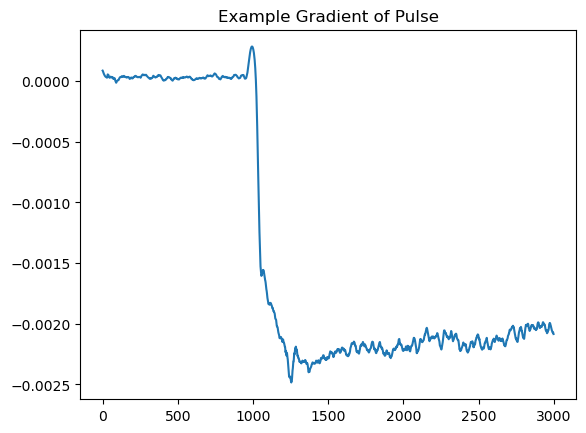

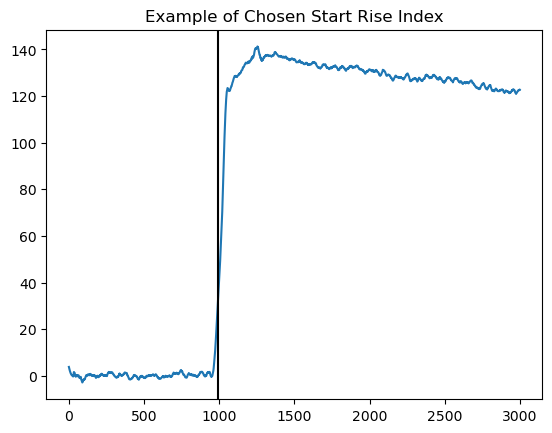

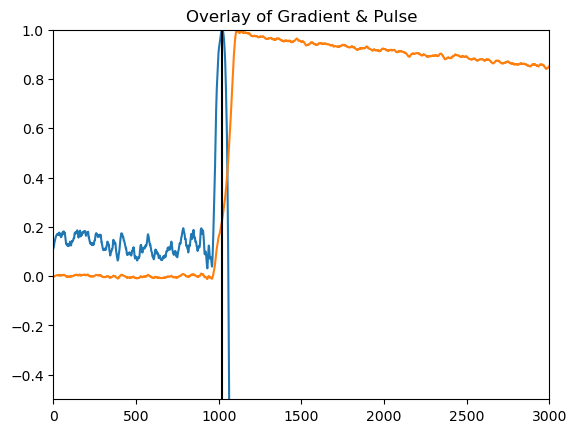

In [14]:
#Version 2 of rise time determination
def get_k_v2(vs,number_rises):
    # vs is a array of signals
    # number_rises is how many signals to process
    k_array = np.ones(number_rises)
    cRMS = [np.array([np.std(vs[i,n:-1]) for n in range(3000)]) for i in range(number_rises)]    
    Gradients = [np.gradient(cRMS[i]) for i in range(number_rises)]
    ks = np.array([np.argmax(Gradients[i]) - np.argmin(Gradients[i]) for i in range(number_rises)])
    i = np.array([np.argmax(Gradients[i]) for i in range(number_rises)]) 
    r = np.array([np.argmin(Gradients[i]) for i in range(number_rises)]) 
    ks = r - i
    return cRMS, Gradients, ks, i ,r

crms, grad, k_v2, i, r = get_k_v2(fs[:10,:], 10)
print("These are rise start values", i)
print("Shape of signals array", f['raw_data'][:10,:].shape)
print("These are the k values", k_v2)

plt.figure()
plt.title("Example Gradient of Pulse")
for i in range(1):
    plt.plot(grad[i])
    
plt.figure()
plt.title("Example of Chosen Start Rise Index")
for i in range(1):
    plt.plot(fs[i,:3000])
plt.axvline(np.argmax(grad[1]), c='k')

plt.figure()
plt.title("Overlay of Gradient & Pulse")
#As you can see in this plot, the max of the gradient is not exactly the start of the signal.
plt.plot(grad[2]/max(grad[2]))
plt.plot(fs[2]/max(fs[2]))
plt.xlim(0,3000)
plt.ylim(-0.5,1)
plt.axvline(np.argmax(grad[2]), c='k')
plt.show()

In [15]:
#Version 3: Chris's version
def determine_rise(signal, sigma=8, window=20, offset=15):
    noise_samp = signal[:500]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    
    grad = np.gradient(np.where(signal > mean+sigma*std, signal, 0))
    
    grad_pos, grad_neg = np.argwhere(grad>2), np.argwhere(grad<-2)
    
    rise_start = 0
    for gp in grad_pos:
        close = False
        for gn in grad_neg:
            if (gp-gn < window and gp-gn >0):
                close = True
        if not close:
            rise_start = gp
            break
    
    return int(rise_start-offset)

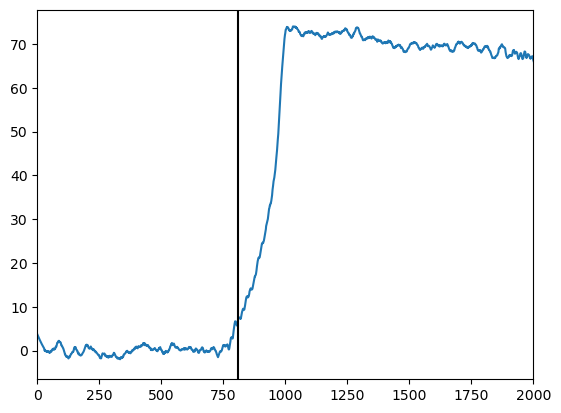

In [16]:
#Testing Version 4 with real signals
i_v4 = []
plt.figure()
for i in range(len(fs)):
    itemp = int(determine_rise(fs[i]))
    i_v4.append(itemp)
i_v4 = np.array(i_v4)
    
for i in range(53,54):
    plt.plot(fs[i])
    plt.xlim(0,2000)
    plt.axvline(i_v4[i], c = 'k')

The mean start rise index is  872.318549692457
The median start rise index is  877.0


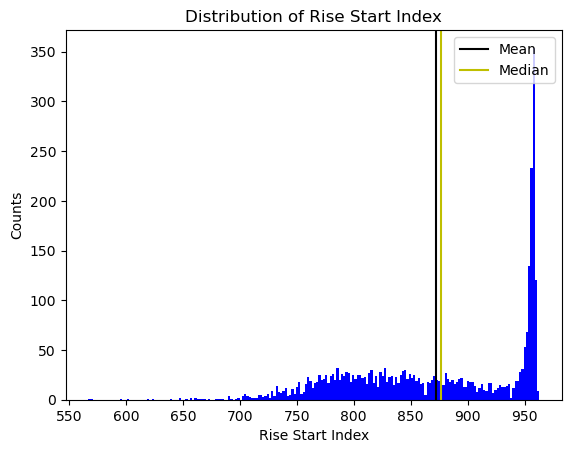

In [17]:
#histogram of version 3 i values
i4_hist, i4_bins = np.histogram(i_v4, bins = 200)
plt.figure()
plt.title("Distribution of Rise Start Index")
plt.xlabel("Rise Start Index")
plt.ylabel("Counts")
plt.hist(i4_bins[:-1], i4_bins, weights = i4_hist, histtype='stepfilled', color = 'b')
plt.axvline(np.mean(i_v4),c='k', label = "Mean")
plt.axvline(np.median(i_v4), c='y', label = "Median")
print("The mean start rise index is ", np.mean(i_v4))
print("The median start rise index is ", np.median(i_v4))
plt.legend()

# Section 9: Finding Tau
 - Defining an exponential function
 - Fitting each pulse to the exp function
 - Finding the decay constant (tau)

In [18]:
#defining an exponential function
def exp_func(x, a, b, c):
    #returns a times e^(-b times a) + c
    return a * np.exp(-b * x) + c

C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


14968.206419342663


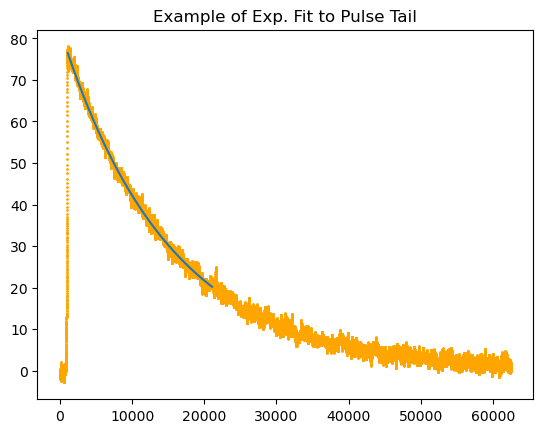

In [19]:
#fit an exponential curve to the decay of each signal to find tau
tau = []
for i in (range(100)):
    #setting the ranges for exp fitting and x axis parameters
    endfit = 20000
    s = imax[i] #index of max for pulse i
    x = np.arange(0, endfit) #array of values from max index upward for some number of indices, len(x)=endfit
    
    #using exp_func over the values in x
    #fits an exp to the ith pulse from index of max to endfit+index of max
    try:
        popt, pcov = curve_fit(exp_func, x, fs[i][s:endfit+s])
        tau.append(1/popt[1])
    except:
        tau.append(0)

tau = list(filter(lambda a: a != 0, tau))
tau = np.array(tau)
tau_avg = np.mean(tau)
print(tau_avg)
    
#plot fitted exponential against bkg sub raw data
plt.title("Example of Exp. Fit to Pulse Tail")
plt.plot(range(s,s+len(exp_func(x, *popt))),exp_func(x, *popt))
plt.scatter(np.arange(0,len(fs[i])),fs[i], s=1, color='orange')

# Section 10: Defining the Trapezoidal Filter
 - Define dkl
 - Define the trapezoid with pole-zero correction

In [20]:
#Define the trapezoidal filter and signal output function
def delay_signal(signal, delay, p=500):
    np.random.seed(9)
    noise_samp = signal[:p]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    noise = np.random.normal(mean, 0.9*std, delay)
    return np.hstack([noise, signal])

def dkl(signal, i, k, l, w=0):
    if w == 0:
        w = int(2.5*k+l)
    vj = signal[i+w:i+w+w] 
    vjk = signal[i+w-k:i+w-k+w]
    vjl = signal[i+w-l:i+w-l+w]
    vjkl = signal[i+w-k-l:i+w-k-l+w]
    dkl_s = vj - vjk - vjl + vjkl
    return dkl_s

def sfunc(signal, start_rise, tau, peaking_time, gap_time, w=0):
    if w == 0:
        w = int(2.5*peaking_time+gap_time)
    ss = []
    dkl_s = dkl(signal, start_rise, peaking_time, peaking_time+gap_time, w)
    for j in range(w):
        if j == 0:
            ss.append(0)
        else:
            ss.append(ss[j-1]*(1+1/tau)+ dkl_s[j])
    return np.array(ss)


# Section 11: Apply Trapezoidal Filter
 - Appling extra noise to the start of the signal
 - Apply trapezoidal filter to the delayed signals

In [21]:
#Gap time set arbitarily here
m=600   

#Peaking time set to match what we see physically in this notebook
k = int(k)
l = k+m
d=int(2.5*k+m)
Tau = int(tau_avg)
print("d is ",d)

#Time to delay the signals
dfs = []
for i in range(len(fs)):
    tempfs = delay_signal(fs[i],delay=d)
    dfs.append(tempfs)
dfs = np.array(dfs)
print("The new length of signals is:", len(dfs[1]))

d is  1475
The new length of signals is: 63975


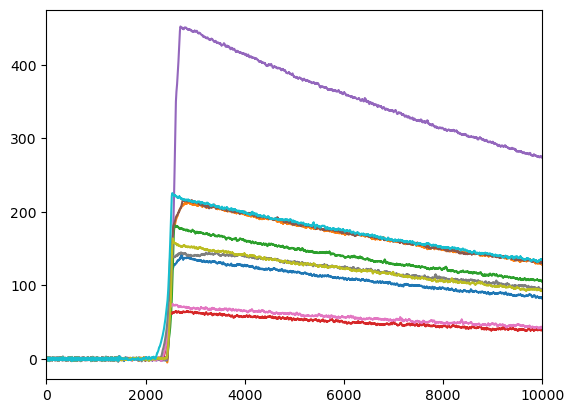

In [22]:
#Plot delayed signals
plt.figure()
plt.xlim(0,10000)
for i in range(10):
    plt.plot(dfs[i])

In [23]:
#Turn these delayed pulses into trapezoids
traps = []
for n in notebook.tqdm(range(len(dfs))):
    trap = sfunc(dfs[n], i_v4[n], Tau, k, m)
    traps.append(trap)

  0%|          | 0/3089 [00:00<?, ?it/s]

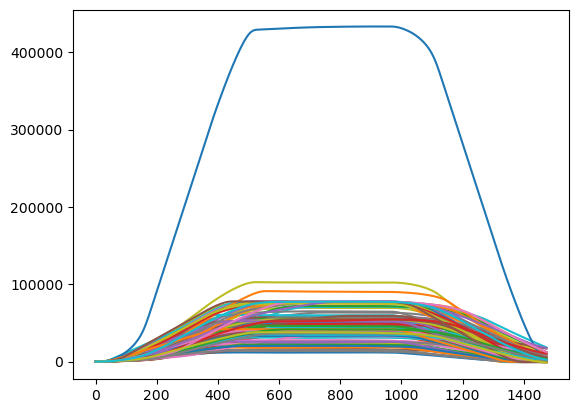

In [24]:
#Plot the trapezoids
plt.figure()
for i in range(300, 400):
    plt.plot(traps[i])

# Section 12: Getting the Mean Height of the Trapezoids
 - Multiple methods used here and optimized in a later notebook
 
 > Max Value Method: Simply, the maximum value of of the trapezoid is taken to be the height of the trapezoid.
 
 > Trapezoid Fitting Method: A peicewise trapezoid function is fit to the signal trapezoid. The resultant start and end of flat top information is used on the signal trapezoid to find the mean height.
 
 > Gradient Method: The second gradient of the signal trapezoid is found and filtered. The two lowest points are found, which should be at the indices of the trapezoid's inflection points. Between these two low points in the second derivative, the first and last zero crossing points should accurately capture the indices of the signal trapezoid's flat top.

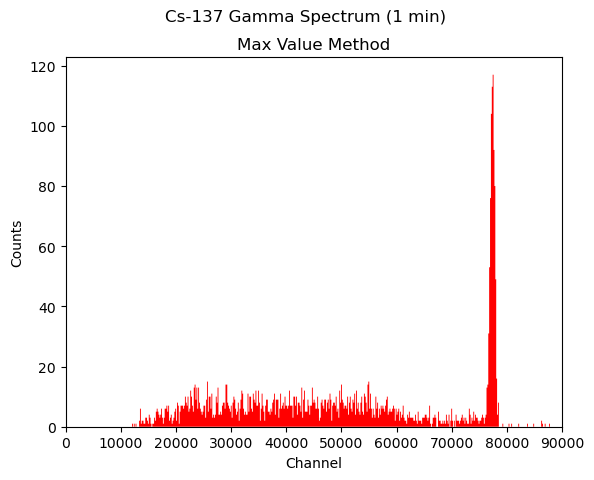

In [25]:
#Max Value Method
trapheight = []
for a1 in range(len(traps)):
    trapheight.append(np.amax(traps[a1]))
height_mv = list(filter(lambda a:a>=0, trapheight))
height_mv = np.array(height_mv)


#Make a histogram of heights(spectrum)
spectrum, bins = np.histogram(height_mv, bins=5000, range=(0,800000))
plt.figure()
plt.xlim(0,90000)
plt.suptitle("Cs-137 Gamma Spectrum (1 min)")
plt.title("Max Value Method")
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.hist(bins[:-1], bins, weights = spectrum, histtype='stepfilled', color = 'r')
plt.show()

In [26]:
def fit_trap(x, topleft, topright, top, ps, pe, e):
    #Trapezoid signal shape
    tr = np.zeros(len(x))
    tr[:int(ps)] = 0
    tr[int(ps):int(topleft)] = ((top-0)/(topleft-ps))*(x[int(ps):int(topleft)]-ps)+0
    tr[int(topleft):int(topright)] = top
    tr[int(topright):int(pe)] = ((e-top)/(pe-topright))*(x[int(topright):int(pe)]-pe)+e
    tr[int(pe):] = e
    return tr

  0%|          | 0/3089 [00:00<?, ?it/s]

C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  0%|          | 0/3089 [00:00<?, ?it/s]

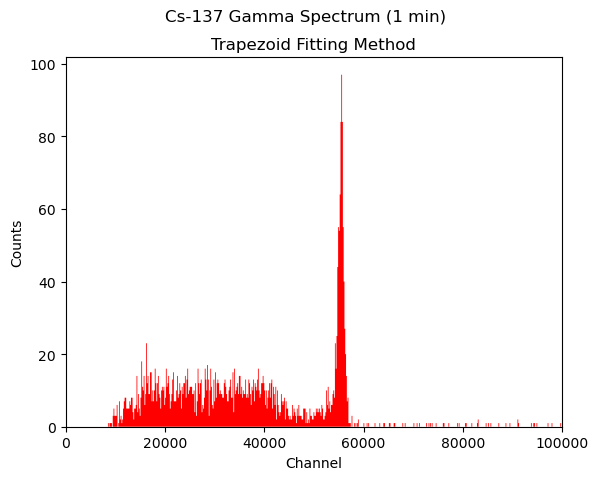

In [27]:
#Trapezoid Fitting Method
#fitting the signal trapezoids using fit_trap
h1 = []
for v1 in notebook.tqdm(range(len(traps)), leave = False):
    try:
        popt, pcov = curve_fit(fit_trap, np.arange(len(traps[v1])), traps[v1], p0=[400, 1200, 100000, 100, 1400, 1500])
        h1.append(popt)
    except:
        h1.append(np.zeros(6))
        
#Trapezoid Fit method cont.
h2 = []
#Remove the zero arrays from h1
for a in range(len(h1)):
    result = h1[a].all(0)
    if result == True:
        h2.append(h1[a])
h2 = np.array(h2)

#find the mean of the top of traps
height2 = []
for b in notebook.tqdm(range(len(h2)), leave = False):
    i1 = int(h2[b][3])
    i2 = int(h2[b][4])
    temph = np.mean(traps[b][i1:i2+1])
    height2.append(temph)
height_tf = list(filter(lambda a: a >= 0, height2))
height_tf = np.array(height_tf)

#Make a histogram of heights(spectrum)
spectrum2, bins2 = np.histogram(height_tf, bins=5000, range=(0,800000))
plt.figure()
plt.xlim(0,100000)
plt.suptitle("Cs-137 Gamma Spectrum (1 min)")
plt.title("Trapezoid Fitting Method")
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.hist(bins2[:-1], bins2, weights = spectrum2, histtype='stepfilled', color = 'r')
plt.show()

Taking Derivatives:   0%|          | 0/3089 [00:00<?, ?it/s]

Finding Bounds of Trapezoid:   0%|          | 0/3089 [00:00<?, ?it/s]

Finding Zero Crossings:   0%|          | 0/3089 [00:00<?, ?it/s]

C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Finding the Height:   0%|          | 0/3089 [00:00<?, ?it/s]

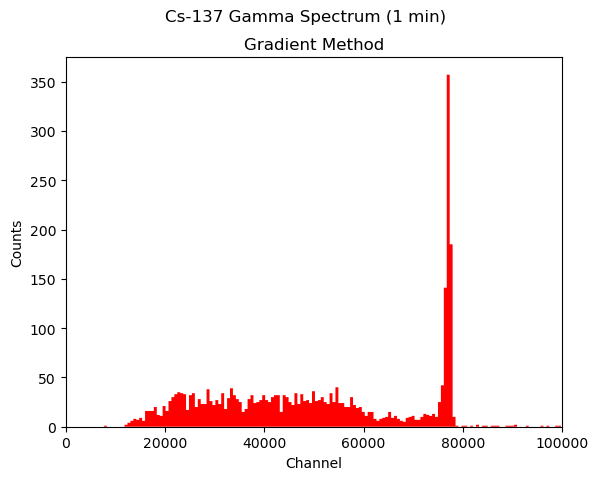

In [28]:
#Using the gradient of the trapezoid to find the flat top (instead of fitting a trapezoid to it)
bound1 = []
bound2 = []
tg = []
tgg = []
for j3 in notebook.tqdm(range(len(traps)), desc = "Taking Derivatives", leave = False):
    tgtemp = np.gradient(traps[j3])
    tggtemp = np.gradient(tgtemp)
    tg.append(tgtemp)
    tgg.append(tggtemp)
tg = np.array(tg)
tgg = np.array(tgg)
ftgg = savgol_filter(tgg, 7, 0)

for i2 in notebook.tqdm(range(len(tgg)), desc = "Finding Bounds of Trapezoid", leave = False):        
    sortedtgg = np.argsort(ftgg[i2])
    minima = []
    maxima = []
    for j2 in range(500):
        diff = np.abs(sortedtgg[j2]-sortedtgg[j2+1])
        if diff > 400:
            minima.append(sortedtgg[j2])
    minima = np.array(minima)

    #minima[0] and minima[1] are the trapezoid top boundaries
    b1 = min(minima[0], minima[1])
    b2 = max(minima[0], minima[1])
    bound1.append(b1)
    bound2.append(b2)

bound1 = np.array(bound1)
bound2 = np.array(bound2)

allzeros = []
for k2 in notebook.tqdm(range(len(ftgg)), desc = "Finding Zero Crossings", leave = False):  
    zeros = []
    for m2 in range(bound2[k2]-bound1[k2]):
        n2 = m2 + bound1[k2]
        if ftgg[k2][n2]*ftgg[k2][n2+1] <= 0:
            zeros.append(n2)
    allzeros.append(zeros)

allzeros = np.array(allzeros)

start = []
end = []
height3 = []
duds = []
for w in notebook.tqdm(range(len(allzeros)), desc = "Finding the Height", leave = False):
    try:
        st = allzeros[w][0]
        ed = allzeros[w][-1]
        start.append(st)
        end.append(ed)
    except:
        start.append(bound1[w])
        end.append(bound2[w])

    #find the mean height
    trapheight = np.mean(traps[w][st:ed])
    height3.append(trapheight)

height_grad = np.array(height3)

#Make a histogram of heights(spectrum)
spectrum2, bins2 = np.histogram(height_grad, bins=5000)
plt.figure()
plt.xlim(0,100000)
plt.suptitle("Cs-137 Gamma Spectrum (1 min)")
plt.title("Gradient Method")
plt.xlabel("Channel")
plt.ylabel("Counts")
plt.hist(bins2[:-1], bins2, weights = spectrum2, histtype='stepfilled', color = 'r')
plt.show()

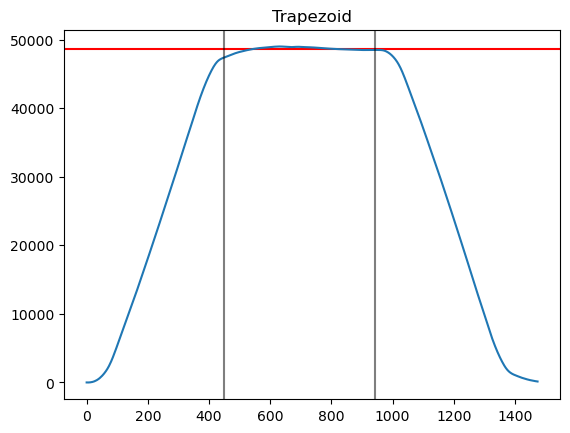

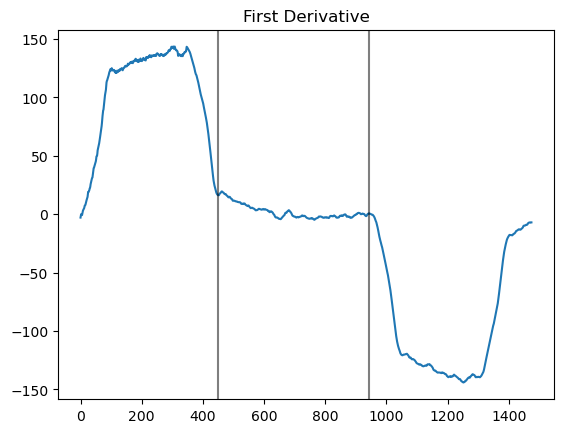

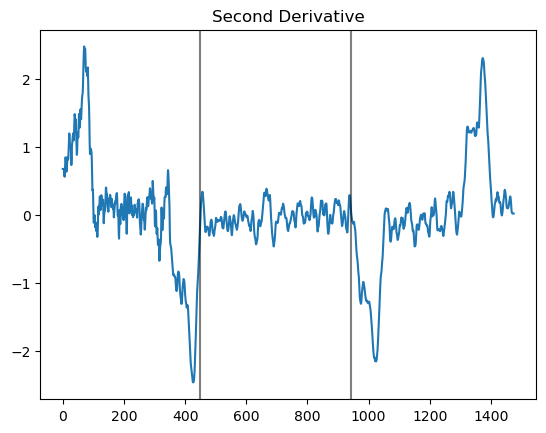

In [29]:
#Gradient Method cont.
#Plotting Signal g Trapezoid, first and second derivatives
g = 0
plt.figure()
plt.title("Trapezoid")
plt.axhline(height_grad[g], c='r')
plt.plot(traps[g])
plt.axvline(start[g], c='k', alpha = 0.5)
plt.axvline(end[g], c='k', alpha = 0.5)

plt.figure()
plt.title("First Derivative")
plt.plot(tg[g])
plt.axvline(start[g], c='k', alpha = 0.5)
plt.axvline(end[g], c='k', alpha = 0.5)

plt.figure()
plt.title("Second Derivative")
plt.plot(ftgg[g])
plt.axvline(start[g], c='k', alpha = 0.5)
plt.axvline(end[g], c='k', alpha = 0.5)